## Instruction
In this notebook, we load data from privious step in `Factor_Process_and_Evaluate.ipynb` and we combine all factors by RandomForest method. Then we can evaluate all factors.

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import helper.project_helper as ph

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8, 4)

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [4]:
## load universe_factors
#fundamental_df = pd.read_csv('fundamental_20170405_20230317.csv').iloc[:,1:]
universe = pd.read_csv('all_zscore_20180405_20230327.csv')
universe['date'] = pd.to_datetime(universe['date'],format='%Y-%m-%d')
universe.set_index(['date'],inplace=True)
universe['pb'] = -universe['pb']
#print(fundamental_df.shape, universe.shape)

### One Hot Prodcast Type

In [5]:
type_dict = {'略减':1, '略增':2, '续盈':3, '预减':4, '首亏':5, '预增':6, '扭亏':7, '续亏':8}

all_factors = universe.copy(deep=True)
type_columns = []
for type_name, type_i in type_dict.items():
    all_factors['type_{}'.format(type_i)] = False
    type_columns.append('type_{}'.format(type_i))
    
for type_name, type_i in type_dict.items():
    all_factors['type_{}'.format(type_i)] = np.where(all_factors['type']==type_name, True, False)
#all_factors.head()

### One Hot Encode Sectors
For the model to better understand the sector data, we'll one hot encode this data.

In [6]:
sector_dict = {'化学制药':1, '医药商业':2, '中成药':3, '生物制药':4}

all_factors = all_factors.copy(deep=True)
sector_columns = []
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = False
    sector_columns.append('sector_{}'.format(sector_i))
    
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = np.where(all_factors['industry']==sector_name, True, False)

all_factors.head()

,ts_code,trade_date,turnover_rate,pe,pb,total_share,free_share,total_mv,circ_mv,name,...,type_3,type_4,type_5,type_6,type_7,type_8,sector_1,sector_2,sector_3,sector_4
date,,,,,,,,,,,,,,,,,,,,,
2018-02-13,300204.SZ,20180213,0.7855,21.5629,-0.0,47781.2254,0.0,567163.1455,553816.3976,舒泰神,...,False,False,False,False,False,False,False,False,False,True
2018-02-14,300204.SZ,20180214,0.6961,20.6365,-0.0,47781.2254,0.0,542794.7205,530021.4218,舒泰神,...,False,False,False,False,False,False,False,False,False,True
2018-02-22,300204.SZ,20180222,0.3041,20.8726,-0.0,47781.2254,0.0,549006.2798,536086.8078,舒泰神,...,False,False,False,False,False,False,False,False,False,True
2018-02-23,300204.SZ,20180223,0.2725,21.0180,-0.0,47781.2254,0.0,552828.7779,539819.3530,舒泰神,...,False,False,False,False,False,False,False,False,False,True
2018-02-26,300204.SZ,20180226,0.3631,21.4176,-0.0,47781.2254,0.0,563340.6475,550083.8524,舒泰神,...,False,False,False,False,False,False,False,False,False,True


### Target
Let's try to predict the go forward 1-week return. When doing this, it's important to quantize the target. The factor we create is the trailing 5-day return.

In [7]:
quantile_jud = all_factors['log-ret'].quantile([0.33,0.66,1.])
quantile_jud

0.33   -0.008607
0.66    0.007394
1.00    0.182592
Name: log-ret, dtype: float64

In [8]:
def get_return_quantiles(all_factors):
    all_factors['return_2q'] = 0
    all_factors['return_2q'] = np.where(all_factors['log-ret']<-0.008, -1, all_factors['return_2q'])
    all_factors['return_2q'] = np.where(all_factors['log-ret']>0.007, 1 , all_factors['return_2q'])
        
    return all_factors

all_factors = get_return_quantiles(all_factors)

### Shift Target
We'll use shifted 5 day returns for training the model.

As some alpha factors measure time is not same, we can also shift.

In [9]:
# save all_factors which is no need to train
universe = all_factors.copy(deep=True)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan)
all_factors['target'] = all_factors.groupby('ts_code')['return_2q'].shift(-5).fillna(0).astype(np.int16)

In [10]:
all_factors['target'].unique()

array([ 1,  0, -1], dtype=int16)

### IID Check of Target
Let's see if the returns are independent and identically distributed.

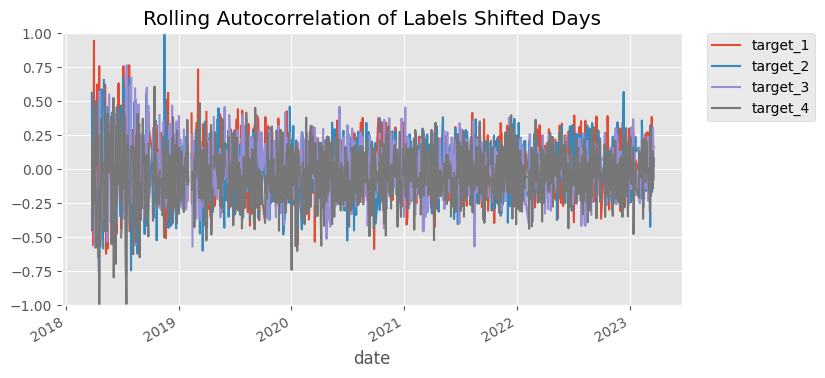

In [11]:
all_factors.reset_index(inplace=True)
all_factors.set_index(['date','ts_code'],inplace=True)
tmp = all_factors.loc[all_factors['trade_date']>20220301]
ph.IID_check(all_factors)

### Train/Valid/Test Splits
Split the data into a train, validation, and test set. For this, we'll use some of the features and the 5 day returns for our target.

In [12]:
features = [ 
            'pb', 'free_share', 'cfps', 'revenue_ps', 'dt_eps', 'bps', 
            'bps_yoy', 'roe_yoy', 'ebt_yoy', 'or_yoy', 'dt_eps_yoy',
            'alpha_close2open_25_sma', 'alpha_supertrend', 'alpha_cci', 'alpha_winlos',
            'alpha_skew2sentiment', 'alpha_peg', 'alpha_turnover', 'alpha_volume', 'alpha_ppo',
            ] + sector_columns + type_columns

target_label = 'target'
print(all_factors.shape)

(53423, 77)


In [13]:
all_factors = all_factors.replace([np.inf, -np.inf], np.nan)
all_factors = all_factors[~all_factors.isin([np.nan, np.inf, -np.inf]).any(1)]
all_factors.reset_index(inplace=True)
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
all_factors = all_factors.set_index(['date','ts_code']).sort_values(by=['date'])
print(all_factors.shape)
all_factors.head()

(53143, 77)


,,trade_date,turnover_rate,pe,pb,total_share,free_share,total_mv,circ_mv,name,industry,...,sector_1,sector_2,sector_3,sector_4,return_2q,target,target_1,target_2,target_3,target_4
date,ts_code,,,,,,,,,,,,,,,,,,,,,
2018-02-13,300204.SZ,20180213,0.7855,21.5629,-0.0,47781.2254,0.0,567163.1455,553816.3976,舒泰神,生物制药,...,False,False,False,True,0,1,-1.0,1.0,0.0,1.0
2018-02-14,300204.SZ,20180214,0.6961,20.6365,-0.0,47781.2254,0.0,542794.7205,530021.4218,舒泰神,生物制药,...,False,False,False,True,-1,0,1.0,0.0,1.0,1.0
2018-02-22,300204.SZ,20180222,0.3041,20.8726,-0.0,47781.2254,0.0,549006.2798,536086.8078,舒泰神,生物制药,...,False,False,False,True,1,1,0.0,1.0,1.0,0.0
2018-02-23,300204.SZ,20180223,0.2725,21.0180,-0.0,47781.2254,0.0,552828.7779,539819.3530,舒泰神,生物制药,...,False,False,False,True,0,-1,1.0,1.0,0.0,1.0
2018-02-26,300204.SZ,20180226,0.3631,21.4176,-0.0,47781.2254,0.0,563340.6475,550083.8524,舒泰神,生物制药,...,False,False,False,True,1,-1,1.0,0.0,1.0,-1.0


In [14]:
tmp = all_factors.dropna().copy()
X = tmp[features]
y = tmp[target_label].astype(np.int16)

X_train, X_valid, X_test, y_train, y_valid, y_test = ph.train_valid_test_split(X, y, 0.7, 0.1, 0.2)

X_test.head()

pb  free_share      cfps  revenue_ps    dt_eps  \
date       ts_code                                                           
2022-03-15 300871.SZ  0.338878   -1.320231  2.228720    0.814554  0.357022   
           300639.SZ -0.126639    0.137349 -0.073071    1.173943  2.615034   
           300204.SZ -2.900826    0.742681 -0.471259   -1.520649 -1.356504   
           002923.SZ -0.478202   -0.882593  0.749215   -0.149867 -0.320221   
           300485.SZ  0.102580    0.404558 -0.819968   -1.160940 -0.459706   

                           bps   bps_yoy   roe_yoy   ebt_yoy    or_yoy  ...  \
date       ts_code                                                      ...   
2022-03-15 300871.SZ -0.139759 -2.209285 -0.762102 -0.733417  0.060727  ...   
           300639.SZ  0.116857 -0.259698  0.521911  0.849778  2.742836  ...   
           300204.SZ -1.423708 -0.775448 -0.912186 -1.081976  0.536002  ...   
           002923.SZ -0.710658  0.125457 -0.334166 -0.259433 -0.561827  ...   
           300485.SZ -0.757107  0.126563 -0.463649 -0.505366 -0.716989  ...   

                      sector_3  sector_4  type_1  type_2  type_3  type_4  \
date       ts_code                                                         
2022-03-15 300871.SZ     False      True   False   False   False   False   
           300639.SZ     False      True   False   False   False   False   
           300204.SZ     False      True   False   False   False   False   
           002923.SZ     False     False   False    True   False   False   
           300485.SZ     False      True   False   False   False   False   

                      type_5  type_6  type_7  type_8  
date       ts_code                                    
2022-03-15 300871.SZ   False    True   False   False  
           300639.SZ   False    True   False   False  
           300204.SZ   False   False   False    True  
           002923.SZ   False   False   False   False  
           300485.SZ   False    True   False   False  

[5 rows x 32 columns]

### Train Random Forests with Different Tree Sizes
Let's build models using different tree sizes to find the model that best generalizes.
#### Parameters
When building the models, we'll use the following parameters.

In [18]:
n_days = 20
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    'criterion': 'entropy',
    #'min_samples_split' : 2000,
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}
n_trees_l = [50, 100]

### Pick Important Features by Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier


train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|█████████████████████████| 2/2 [00:03<00:00,  1.85s/Model]


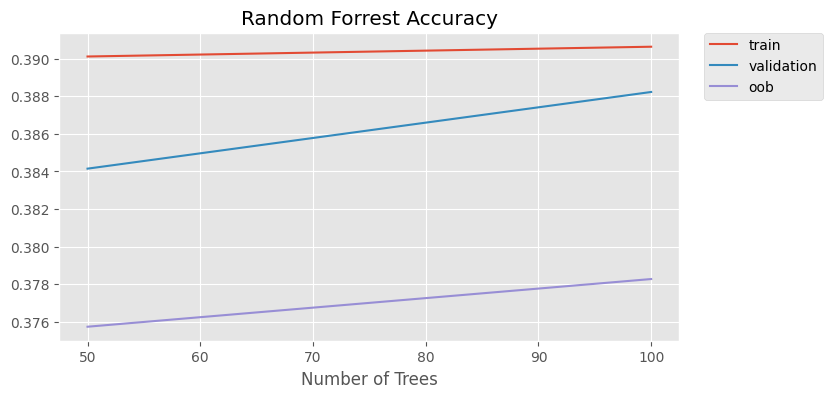

Features Ranked by Average Importance:

      Feature                     Importance
 1. alpha_volume            (0.3243025667170535)
 2. pb                      (0.14124314327962767)
 3. alpha_turnover          (0.13829512965063945)
 4. alpha_ppo               (0.06146569288297789)
 5. alpha_supertrend        (0.06109074041475407)
 6. sector_4                (0.03849933191357771)
 7. bps                     (0.030857200013220506)
 8. ebt_yoy                 (0.027436216911378028)
 9. dt_eps                  (0.024172320494108057)
10. alpha_winlos            (0.021581337402306937)
11. cfps                    (0.020416046739681074)
12. free_share              (0.01758899771304511)
13. revenue_ps              (0.015958384740247723)
14. alpha_close2open_25_sma (0.011877017372661081)
15. bps_yoy                 (0.011071434021966501)
16. or_yoy                  (0.010910796956161897)
17. alpha_skew2sentiment    (0.007559222147744285)
18. dt_eps_yoy              (0.007428363869472323)
19. r

In [20]:
ph.plot(
    [n_trees_l]*4,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')
print('Features Ranked by Average Importance:\n')
ph.rank_features_by_importance(np.average(feature_importances, axis=0), features)

### Build an ensemble of non-overlapping trees
The last method is to create ensemble of non-overlapping trees. Here we are going to write a custom `scikit-learn` estimator. We inherit from `VotingClassifier` and we override the `fit` method so we fit on non-overlapping periods.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import Bunch

class NoOverlapVoter(VotingClassifier):
    
    def _calculate_oob_score(self, classifiers):
        oob = 0
        for clf in classifiers:
            oob = oob + clf.oob_score_
        return oob / len(classifiers)
        
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        estimators_ = []
        for i in range(n_skip_samples):
            estimators_.append(
                classifiers[i].fit(x[i::n_skip_samples], y[i::n_skip_samples])
            )
        return estimators_
    
    def __init__(self, estimator, voting='soft', n_skip_samples=4):
        # List of estimators for all the subsets of data
        estimators = [('clf'+str(i), estimator) for i in range(n_skip_samples + 1)]
        
        self.n_skip_samples = n_skip_samples
        super().__init__(estimators, voting=voting)
    
    def fit(self, X, y, sample_weight=None):
        estimator_names, clfs = zip(*self.estimators)
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        clone_clfs = [clone(clf) for clf in clfs]
        self.estimators_ = self._non_overlapping_estimators(X, y, clone_clfs, self.n_skip_samples)
        self.named_estimators_ = Bunch(**dict(zip(estimator_names, self.estimators_)))
        self.oob_score_ = self._calculate_oob_score(self.estimators_)
        
        return self

### Train Model

In [22]:
X_train.shape

(30716, 32)

In [27]:
n_days = 5
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    'criterion': 'entropy',
    #'min_samples_split' : 500,
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees_l = [50, 70, 80]

train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)

Training Models: 100%|█████████████████████████| 3/3 [00:08<00:00,  2.81s/Model]


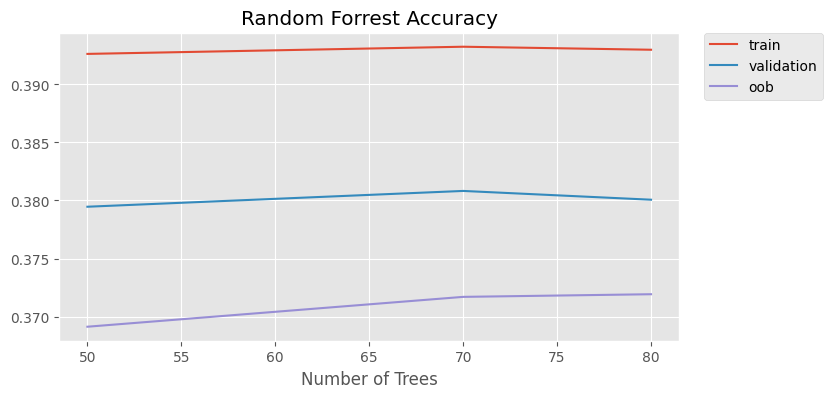

In [28]:
ph.plot(
    [n_trees_l]*4,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Predict on the test data
predictions = clf_nov.predict(X_valid)

# Score our model average='micro' if report error
print('Accuracy score: ', format(accuracy_score(y_valid.values, predictions)))
print('Precision score: ', format(precision_score(y_valid.values, predictions, average='micro')))
print('Recall score: ', format(recall_score(y_valid.values, predictions, average='micro')))
print('F1 score: ', format(f1_score(y_valid.values, predictions, average='micro')))

Accuracy score:  0.38006654567453113
Precision score:  0.38006654567453113
Recall score:  0.38006654567453113
F1 score:  0.38006654567453113


In [30]:
'''
 1. alpha_volume            (0.23726969844790138)
 2. alpha_turnover          (0.08921249337194437)
 3. pb                      (0.08479026445221303)
 4. alpha_supertrend        (0.07254942510631128)
 5. alpha_ppo               (0.06924616003768318)
 6. bps                     (0.04062076828882832)
 7. alpha_close2open_25_sma (0.035140663339455015)
 8. alpha_kama              (0.033980309890269816)
 9. alpha_winlos            (0.03190892927725047)
10. ebt_yoy                 (0.03085792711311312)
'''

factor_names = [ 
            'alpha_volume', 'pb', 'alpha_ppo', 'alpha_turnover','alpha_supertrend',
            'alpha_winlos', 'alpha_skew2sentiment', 'alpha_peg', 'alpha_close2open_25_sma',
            ]

all_pricing = all_factors.reset_index().pivot(index='date', columns='ts_code', values='close')
all_pricing.head()

tmp = all_factors.copy(deep=True)
tmp['close'] = all_factors.groupby('ts_code')['close'].shift(-2)
tmp.loc[tmp.index.get_level_values(1) == '603538.SH']['close']
all_pricing = tmp.reset_index().pivot(index='date', columns='ts_code', values='close')

### Evalueate alpha factor

In [31]:
import alphalens as al
from scipy.stats import zscore

def show_sample_results(data, samples, classifier, factors, pricing=all_pricing):
    # Calculate the Alpha Score
    prob_array=[-1, 0, 1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    # Add Alpha Score to rest of the factors
    alpha_score_label = 'alpha_AI'
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
    factors_with_alpha = factors_with_alpha.reset_index()
    factors_with_alpha[[alpha_score_label,'close']] = factors_with_alpha.groupby('date')[[alpha_score_label,'close']].apply(zscore)
    factors_with_alpha = factors_with_alpha.set_index(['date','ts_code']).sort_values(by=['date'])
    
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = ph.build_factor_data(factors_with_alpha[factors + [alpha_score_label]], pricing, holding_time=10)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = ph.get_factor_returns(factor_data)
    sharpe_ratio = ph.sharpe_ratio(factor_returns)
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    ph.plot_factor_returns(factor_returns)
    ph.plot_factor_rank_autocorrelation(factor_data)

Cleaning Data...

Dropped 0.6% entries from factor data: 0.0% in forward returns computation and 0.6% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.0% in forward returns computation and 0.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.0% in forward returns computation and 0.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.0% in forward returns computation and 0.4% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.3% entries from factor data: 0.0% in forward returns computation and 0.3% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

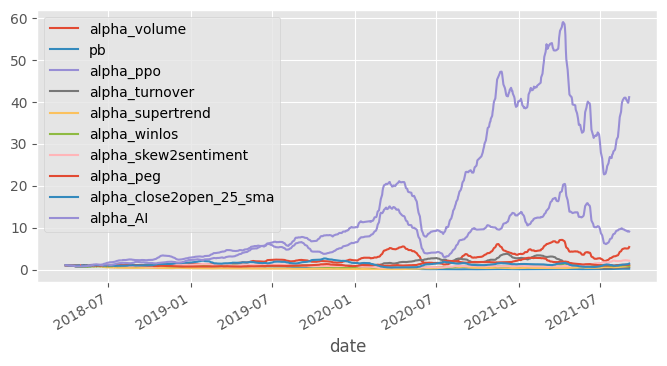

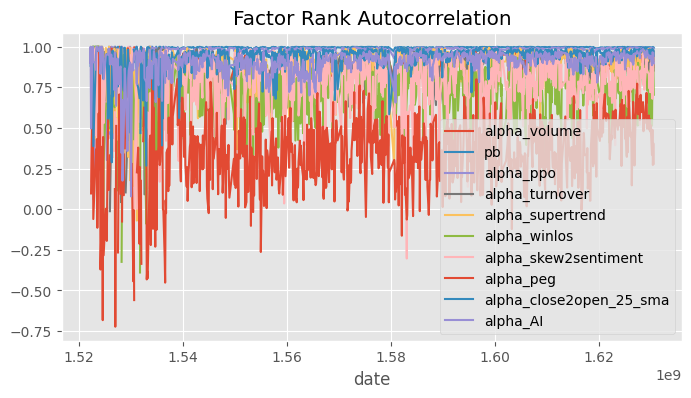

In [32]:
show_sample_results(all_factors, X_train, clf_nov, factor_names, pricing=all_pricing)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

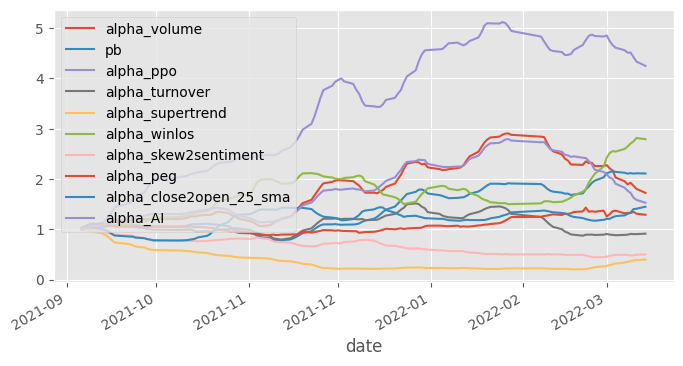

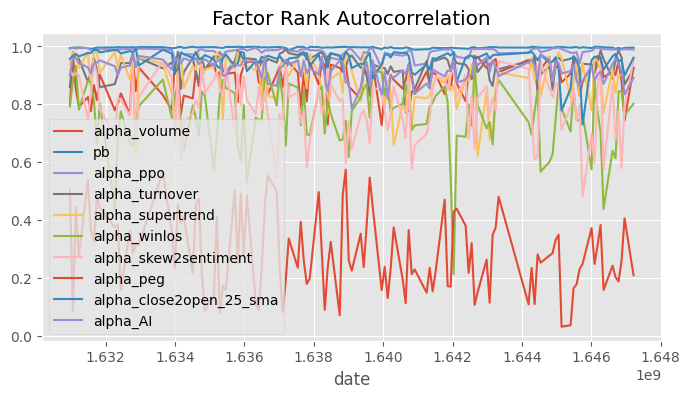

In [33]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names, pricing=all_pricing)

## Final Model
### Re-Training Model
In production, we would roll forward the training. Typically you would re-train up to the "current day" and then test. Here, we will train on the train & validation dataset.

In [40]:
n_days = 5
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    'criterion': 'entropy',
    #'min_samples_split' : 1000,
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees = 100

train_score = []
valid_score = []
oob_score = []

clf = RandomForestClassifier(n_trees, **clf_parameters)
    
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(
    pd.concat([X_train, X_valid]),
    pd.concat([y_train, y_valid]))

train_score.append(clf_nov.score(X_train, y_train.values))
valid_score.append(clf_nov.score(X_valid, y_valid.values))
oob_score.append(clf_nov.oob_score_)

In [41]:
print(train_score)
print(valid_score, oob_score)

[0.39354082562833703]
[0.3935269207501512] [0.3755357908272611]


### View Train Set Results

Cleaning Data...

Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

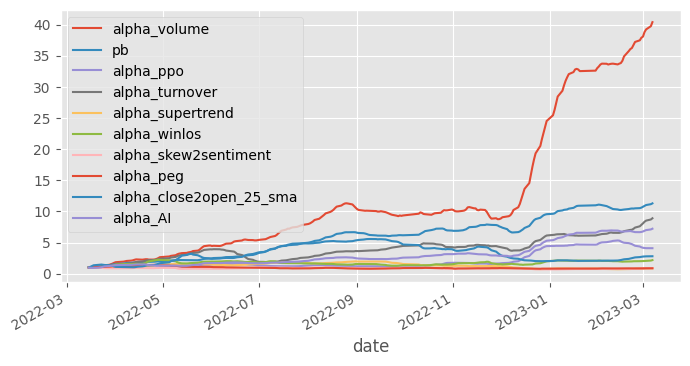

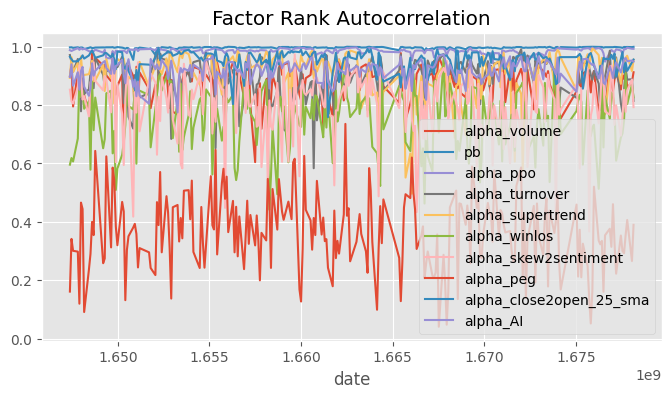

In [42]:
#show_sample_results(all_factors, pd.concat([X_train, X_valid]), clf_nov, factor_names, pricing=all_pricing)
show_sample_results(all_factors, X_test, clf_nov, factor_names, pricing=all_pricing)

### View Test Set Results

Cleaning Data...

Dropped 1.5% entries from factor data: 1.2% in forward returns computation and 0.3% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 1.3% entries from factor data: 1.2% in forward returns computation and 0.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 1.3% entries from factor data: 1.2% in forward returns computation and 0.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 1.6% entries from factor data: 1.2% in forward returns computation and 0.4% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 1.3% entries from factor data: 1.2% in forward returns computation and 0.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

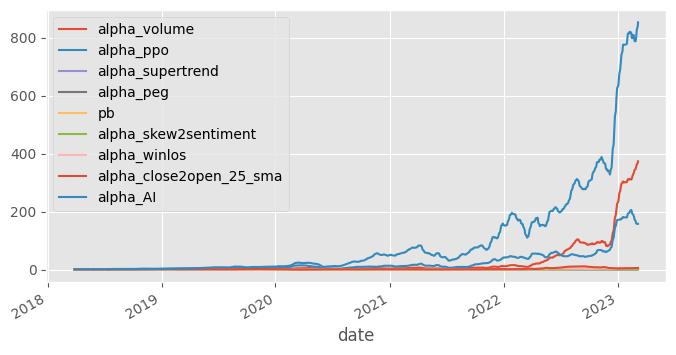

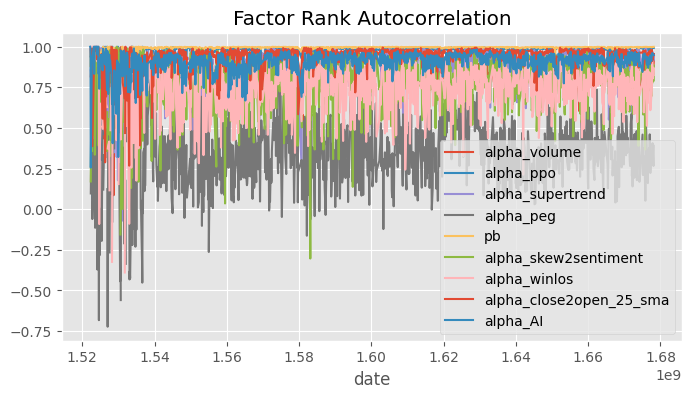

In [43]:
factor_names = [
                'alpha_volume', 'alpha_ppo','alpha_supertrend', 'alpha_peg', 'pb',
                'alpha_skew2sentiment', 'alpha_winlos', 'alpha_close2open_25_sma',
           ]
tmp = pd.concat([X_train, X_valid])
tmp = pd.concat([tmp, X_test])
show_sample_results(all_factors, tmp, clf_nov, factor_names, pricing=all_pricing)

### Merage AI factors

In [ ]:
def save_AI_factors(data, classifier):
    # Calculate the Alpha Score
    samples = data[features]
    prob_array=[-1,0,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))

    # Add Alpha Score to rest of the factors
    alpha_score_label = 'alpha_AI'
    print(alpha_score, len(alpha_score))
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
    factors_with_alpha = factors_with_alpha.reset_index()
    factors_with_alpha[[alpha_score_label,'close']] = factors_with_alpha.groupby('date')[[alpha_score_label,'close']].apply(zscore)
    factors_with_alpha = factors_with_alpha.set_index(['date','ts_code']).sort_values(by=['date'])
    
    return factors_with_alpha
    
save_factors = save_AI_factors(all_factors, clf_nov)
save_factors = save_factors.reset_index().set_index(['date'])
save_factors = universe.merge(save_factors[['alpha_AI','ts_code','trade_date']], on=['ts_code','trade_date'], how='left')

In [ ]:
'''
 Sharpe Ratios
volume                 -2.13
supertrend             -1.68
alpha_skew2sentiment    1.74
alpha_winlos            1.74
alpha_atr              -2.15
alpha_turnover          1.35
alpha_cci               0.51
alpha_AI                2.48
dtype: float64
'''

save_factors['alpha_pb'] = -save_factors['pb']
field = ['ts_code', 'trade_date', 'name', 'industry', 'close', 'log-ret', 'return_2q', 
       'alpha_pb','alpha_volume', 'alpha_ppo', 'alpha_skew2sentiment','alpha_winlos','alpha_AI']
save_factors[field].to_csv('factors_AI_20180405_20230317.csv')